In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import pickle
import string
import random
from numpy import dot
from numpy.linalg import norm
from itertools import combinations

import nltk
nltk.download('stopwords')
#nltk.download('wordnet')
from nltk.corpus import stopwords

#import gensim
from gensim import corpora, models, similarities, matutils

# sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/willstith/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
jdf = pd.read_json('data/jeopardy.json')
jdf.shape

(216930, 7)

(array([1179.,   52.,  836.,  346., 1009.,  502.,  422.,  859.,  112.,
         780.,  446., 2500., 2734.,  668.,  533.,  850.,  122., 1588.,
         539.,  792., 1037.,  181.,  955.,  240., 1319., 1209., 2842.,
        5690., 6162., 6156., 6114., 6126., 6159., 6139., 5984., 6308.,
        6138., 4761., 1023., 4602., 5990., 4548., 3443., 6278., 6313.,
        6362., 6279., 6346., 6176., 6366., 6308., 6346., 6358., 6338.,
        6314., 6256., 6261., 6188., 6256., 6190.]),
 array([1.00000000e+00, 1.05983333e+02, 2.10966667e+02, 3.15950000e+02,
        4.20933333e+02, 5.25916667e+02, 6.30900000e+02, 7.35883333e+02,
        8.40866667e+02, 9.45850000e+02, 1.05083333e+03, 1.15581667e+03,
        1.26080000e+03, 1.36578333e+03, 1.47076667e+03, 1.57575000e+03,
        1.68073333e+03, 1.78571667e+03, 1.89070000e+03, 1.99568333e+03,
        2.10066667e+03, 2.20565000e+03, 2.31063333e+03, 2.41561667e+03,
        2.52060000e+03, 2.62558333e+03, 2.73056667e+03, 2.83555000e+03,
        2.94053333

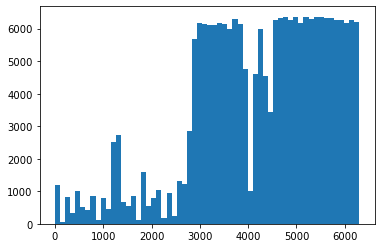

In [3]:
plt.hist(jdf['show_number'], bins=60)

Both because the dataset is very large, and because older clues might be outdated or reflect a different style, I decided to get rid of all clues older than a certain date. I decided a good cutoff for the "modern era" would be the beginning of Season 20, when the show did away with its 5-game limit for returning champions. This reduce my dataset from 216,930 clues to 111,162 clues.

In [4]:
jdf = jdf[jdf['show_number'] >= 4380] #first show in the dataset following the beginning of Season 20

I'm also getting rid of all clues containing a link to a picture or video. Many of the clues consist of only the link and lack specific interpretive value. Many others contain dead links, which I would not like to be included in a future training app. This leaves me with 101,742 clues.

In [5]:
#remove all non-text clues (audio/picture/video)
jdf = jdf[~jdf['question'].str.contains('href')]

In [6]:
jdf['qanda'] = jdf['question'] + ' ' + jdf['answer']

In [7]:
jdf['qandacat'] = jdf['qanda'] + ' ' + jdf['category']

Because each individual question and answer is so short, I might be able to obtain better topics by grouping whole categories together as a single document. Categories normally consist of 5 questions each, but there is more variance in jdf because I've dropped certain Qs and also some Qs are left buried when time runs out in a Jeopardy! match. The ['qanda5'] or ['qanda5cat'] column can serve as the corpus in that case.

In [8]:
#jdf['qanda5'] = jdf.groupby(['show_number', 'round', 'category'])['qanda'].transform(lambda x: ' '.join(x))

In [9]:
#jdf['qanda5cat'] = jdf['qanda5'] + ' ' + jdf['category']

In [10]:
#taking a smaller sample to work with
#jdf = jdf.head(100000)
#save questions to use later in question suggester
jdf_qanda = jdf[['question', 'answer', 'category']].copy()

In [11]:
jdf_qanda['idx'] = jdf.index.copy()
jdf_qanda['question'] = (jdf_qanda['idx'].apply(str) + ' ' + jdf_qanda['category'].apply(str) + ': ' + jdf_qanda['question'].apply(str))
jdf_qanda['answer'] = (jdf_qanda['idx'].apply(str) + ' ' + jdf_qanda['answer'].apply(str))
jdf_qanda['category'] = (jdf_qanda['idx'].apply(str) + ' ' + jdf_qanda['category'].apply(str))

In [12]:
corpus = list(jdf['qandacat'])
#delete old df in order to save space
del jdf
#strip punctuation
corpus = [qanda.translate(str.maketrans('', '', string.punctuation)).lower() for qanda in corpus]

**Stop Words**

In [16]:
stop_words = stopwords.words('english')
stop_words.extend(['thats','also','could','would','im','like','names','name','named','br'])
#strip stop_word punctuation so it matches corpus
stop_words = [word.translate(str.maketrans('', '', string.punctuation)) for word in stop_words]

**TF-IDF with NMF (best combination)**

In [17]:
#only unigrams but the token pattern also allows for important specifically defined bigrams to be included
tfidf2 = TfidfVectorizer(ngram_range=(1,1),
                         stop_words=stop_words, token_pattern="\\b[a-z]+_?[a-z]+\\b")
tfidf2.fit(corpus)
corpus_tf2 = tfidf2.transform(corpus)

In [18]:
from sklearn.decomposition import NMF

nmf2 = NMF(n_components=25, random_state=23)
corpus_tf2_nmf = nmf2.fit_transform(corpus_tf2)
corpus_tf2_nmf.shape
#save this doc-topic matrix as a dataframe to use later
corpus_tf2_nmf_df = pd.DataFrame(corpus_tf2_nmf)

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


In [19]:
corpus_tf2_nmf_df = pd.DataFrame(corpus_tf2_nmf)
corpus_tf2_nmf_df['question'] = jdf_qanda['question']
corpus_tf2_nmf_df['answer'] = jdf_qanda['answer']

In [20]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(nmf2.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [21]:
display_topics(nmf2, tfidf2.get_feature_names(), 20)


Topic  0
day, national, park, years, year, may, holiday, days, april, holidays, month, week, every, observances, june, celebrated, parks, st, died, november

Topic  1
state, official, states, capital, capitals, university, union, texas, california, park, secretary, college, virginia, florida, nicknames, alaska, washington, georgia, bird, hawaii

Topic  2
one, number, another, letter, famous, largest, good, says, worlds, change, borders, might, need, million, animals, theres, may, many, two, big

Topic  3
first, became, lady, woman, ladies, alphabetically, year, firsts, sports, published, win, american, women, female, history, space, opened, major, elected, years

Topic  4
word, comes, meaning, latin, origins, greek, means, french, phrase, english, old, letter, term, adjective, spanish, mean, may, get, derived, dictionary

Topic  5
new, york, times, jersey, mexico, orleans, zealand, hampshire, england, governor, states, testament, years, news, college, year, yankees, street, cities, ol

**Custom Quiz Generator**

In [22]:
def cosine_similarity(doc1, doc2):
    '''Finds cosine similarity between two rows of doc-term matrix'''
    cosine = dot(doc1, doc2) / (norm(doc1) * norm(doc2))                         
    return cosine

In [23]:
cosine_similarity(corpus_tf2_nmf[0], corpus_tf2_nmf[1])

0.07348890188311234

In [24]:
#outputs 10 most similar questions to the one I got wrong
def get_closest_qs(doc, doc_term, questions, no_qs):
    '''Finds cosine similarity between one question and all others, then returns the n-most similar questions'''
    results = []
    for idx, _ in enumerate(doc_term):
        results.append(cosine_similarity(doc, doc_term[idx]))    
    return list(zip(questions.iloc[np.argsort(results)[-no_qs:]],results))

In [54]:
get_closest_qs(corpus_tf2_nmf[34538], corpus_tf2_nmf, jdf_qanda['question'], no_qs=10)

[('166385 AMERICAN WOMEN NOVELISTS: \'The author of "A Stranger is Watching", she\'s been called "America\'s Queen of Suspense"\'',
  0.10024014904518536),
 ('157560 WELL, "B"!: \'In Exodus 2:3 baby Moses is cruising down the Nile River in a basket made from these\'',
  0.2774838326995913),
 ('42881 AMERICAN POETS & POETRY: \'This line follows "Poems are made by fools like me"\'',
  0.0022459164545551758),
 ('55468 AMERICAN LIT: \'A Hemingway story is called "The Short Happy Life of" him\'',
  0.30287517783359585),
 ("29145 POTENT POTABLES: 'With brands like Old Overholt, whiskey made from this grain, not corn, was once a favorite of the American sot'",
  0.18189736055551123),
 ('178310 ROBERT LOUIS STEVENSON: \'When Stevenson wrote this tale in 1881, it was called "The Sea-Cook"\'',
  0.0),
 ('192982 AMERICAN POETRY: \'In what he called a favorite poem, Wallace Stevens wrote, "The only emperor is the emperor of this dessert treat"\'',
  0.7569429459719069),
 ('56077 AUTHORS\' QUOTATIO

In [25]:
# #use this to get answers from quiz (no functional advantage to simply accessing the dataframe answers as shown below)
# def get_closest_as(indices, answers):
#     '''Returns answers corresponding to the questions whose indices are provided in the form of a list'''
#     for i in indices:
#         print(str(answers.loc[answers['idx'] == i, 'answer'].iloc[0]))

In [50]:
# get_closest_as([195340], jdf_qanda)

195340 (Eero) Saarinen


**Get Random Question**

In [ ]:
pd.set_option('display.max_columns', None)

In [3]:
def get_q(questions):
    x = np.random.randint(0,100000)
    return questions.iloc[x,0]

In [53]:
get_q(jdf_qanda)

"34538 FIRST ELECTED OFFICE: 'This New York junior senator's first elected office was... New York junior senator'"

In [59]:
jdf_qanda['answer'][34538]

'34538 Hillary Clinton'

**Count Vectorizer with LDA**

In [ ]:
count_vectorizer = CountVectorizer(ngram_range=(1,2),  
                                   stop_words=stop_words, token_pattern="\\b[a-z][a-z]+\\b")

count_vectorizer.fit(corpus)
corpus_cv1 = count_vectorizer.transform(corpus).transpose()

In [ ]:
corpus_cv1.shape

In [ ]:
pd.DataFrame(corpus_cv1.toarray(), count_vectorizer.get_feature_names()).shape

In [ ]:
unsparse_cv1 = matutils.Sparse2Corpus(corpus_cv1)

In [ ]:
id2word = dict((v, k) for k, v in count_vectorizer.vocabulary_.items())

In [ ]:
len(id2word)

In [ ]:
lda30 = models.LdaModel(corpus=unsparse_cv1, num_topics=30, id2word=id2word, passes=5)

In [ ]:
lda30.print_topics()

**TF-IDF with LDA**

In [ ]:
tfidf1 = TfidfVectorizer(ngram_range=(1,2),
                         stop_words=stop_words, token_pattern="\\b[a-z][a-z]+\\b")

tfidf1.fit(corpus)
corpus_tf1 = tfidf1.transform(corpus).transpose()

In [ ]:
pd.DataFrame(corpus_tf1.toarray(), tfidf1.get_feature_names()).shape

In [ ]:
unsparse_tf1 = matutils.Sparse2Corpus(corpus_tf1)

In [ ]:
id2word = dict((v, k) for k, v in tfidf1.vocabulary_.items())

In [ ]:
lda_tf_30 = models.LdaModel(corpus=unsparse_tf1, num_topics=30, id2word=id2word, passes=5)

In [ ]:
lda_tf_30.print_topics()